# BERT hierarchical multi-class classification model Creation 

In [17]:
# Imports 
import pandas as pd
import re
import torch
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import random
from tqdm.notebook import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc

## Dataset Creation & Cleaning Functions 

In [18]:
# Get Dataset from FILE_PATH, use CALS as headers 
def get_dataset(FILE_PATH, COLS):
    df = pd.read_csv(FILE_PATH, names=COLS, index_col=False)
    df.head() 
    return df

### Data Cleaning Functions

In [19]:
# Clean Text function - use reges to remove non alphanumeric characters, remove common key words from data source 
def clean_text(text):
    # Remove non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text)

    # Remove specified words
    words_to_remove = ['tesco', 'tescos', 'sainsbury', 'sainsburys']
    pattern = re.compile(r'\b(' + '|'.join(words_to_remove) + r')\b', re.IGNORECASE)
    text = pattern.sub("", text)

    # Remove extra spaces
    text = ' '.join(text.split())

    return text

In [20]:
# Remove quantity based text, remove common quantaties 
def remove_quantities(text):
    # Remove quantities like '4 pack', '500g', '1kg', etc.
    pattern = r"\b\d+\s*(pack|g|kg|ml|l|oz|lb)\b"
    text_without_quantities = re.sub(pattern, "", text, flags=re.IGNORECASE)
    
    # Remove standalone numbers
    pattern = r"\b\d+\b"
    text_without_quantities = re.sub(pattern, "", text_without_quantities)
    
    return text_without_quantities

## Pre-Processing Functions

In [21]:
# Encoding Labels, returns the label dictionary 
def encode_labels(df):
    possible_labels = df.CATEGORY.unique()
    label_dict = {}
    for index, possible_label in enumerate(possible_labels):
        label_dict[possible_label] = index
    print(label_dict)
    return possible_labels, label_dict

## Train Test Split 

In [22]:
# Train test split, edits dataframe. Randomizes data.
def tts_df(df):
    df = df.sample(frac=1, random_state=42)

    x_train, x_val, y_train, y_val = train_test_split(
        df.index.values,
        df.label.values,
        test_size=0.2,
        random_state=42,
        stratify=df.label.values
    )

    df['data_type'] = ['not_set']*df.shape[0]

    df.loc[x_train, 'data_type'] = 'train'
    df.loc[x_val, 'data_type'] = 'val'

    df.groupby(['CATEGORY', 'label', 'data_type']).count()

    return df, x_train, x_val, y_train, y_val

## Tokenization 

In [23]:
# Tokenizes and inputted dataframe, returns 2 TensorDatasets for training and validation
def tokenize_df(df):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                            do_lower_case=True)

    encoded_data_train = tokenizer.batch_encode_plus(
        df[df.data_type=='train'].NAME.values,
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=512,
        return_tensors='pt',
    )


    encoded_data_val = tokenizer.batch_encode_plus(
        df[df.data_type=='val'].NAME.values, 
        add_special_tokens=True, 
        return_attention_mask=True, 
        pad_to_max_length=True, 
        max_length=256, 
        return_tensors='pt'
    )

    input_ids_train = encoded_data_train['input_ids']
    attention_masks_train = encoded_data_train['attention_mask']
    labels_train = torch.tensor(df[df.data_type=='train'].label.values)

    input_ids_val = encoded_data_val['input_ids']
    attention_masks_val = encoded_data_val['attention_mask']
    labels_val = torch.tensor(df[df.data_type=='val'].label.values)

    dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
    dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

    return dataset_train, dataset_val



## Pre-training and Training Functions

In [24]:
# Performance Metrics 

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [25]:
def evaluate(dataloader_val, model, device):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    true_probs, predicted_probs = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        true_probs.append(label_ids.flatten())
        predicted_probs.append(logits)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    true_probs = np.concatenate(true_probs, axis=0)
    predicted_probs = np.concatenate(predicted_probs, axis=0)
            
    return loss_val_avg, predictions, true_vals, true_probs, predicted_probs


## Training 

In [26]:
def training_loop(model, epochs, dataloader_train, dataloader_validation, device, optimizer, scheduler, SAVE_PATH):
    training_stats = []
    for epoch in tqdm(range(1, epochs+1)):
        
        model.train()
        
        loss_train_total = 0
        correct_train_total = 0
        total_train_samples = 0

        progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
        for batch in progress_bar:

            model.zero_grad()
            
            batch = tuple(b.to(device) for b in batch)
            
            inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'labels':         batch[2],
                    }       

            outputs = model(**inputs)
            
            loss = outputs[0]
            logits = outputs[1]
            loss_train_total += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            # Calculate accuracy
            preds = torch.argmax(logits, dim=1)
            correct_train_total += (preds == inputs['labels']).sum().item()
            total_train_samples += inputs['labels'].size(0)
            
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
            
            
        torch.save(model.state_dict(), f'{SAVE_PATH}/finetuned_BERT_epoch_{epoch}.model')
            
        tqdm.write(f'\nEpoch {epoch}')
        
        loss_train_avg = loss_train_total/len(dataloader_train)            
        tqdm.write(f'Training loss: {loss_train_avg}')
        
        val_loss, predictions, true_vals, preds_flat, true_probs = evaluate(dataloader_validation, model, device)
        val_f1 = f1_score_func(predictions, true_vals)
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (Weighted): {val_f1}')
        train_accuracy = correct_train_total / total_train_samples
        training_stats.append({
            'epoch': epoch,
            'Training Loss': loss_train_avg,
            'Valid. Loss': val_loss,
            'Training Accur.': train_accuracy,  # You will need to calculate the training accuracy
            'Valid. Accur.': val_f1,
        })
    return training_stats

## Testing 

In [27]:
def load_test(label_dict, device, dataloader_validation, SAVE_PATH):
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                        num_labels=len(label_dict),
                                                        output_attentions=False,
                                                        output_hidden_states=False)

    model.to(device)

    model.load_state_dict(torch.load(f'{SAVE_PATH}/finetuned_BERT_epoch_4.model', map_location=torch.device('cuda')))

    val_loss, predictions, true_vals, preds_flat, true_probs = evaluate(dataloader_validation, model=model, device=device)
    accuracy_per_class(predictions, true_vals, label_dict)
    return val_loss, predictions, true_vals, preds_flat, true_probs

## Data Visualisation Functions

In [28]:
## Confusion Matrix 
def plot_confusion_matrix(y_true, y_pred, label_names):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [29]:
def plot_bar_charts(training_stats):
    df_stats = pd.DataFrame(training_stats)
    df_stats = df_stats.set_index('epoch')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    ax1.plot(df_stats['Training Loss'], label="Training Loss")
    ax1.plot(df_stats['Valid. Loss'], label="Validation Loss")
    ax1.set_title("Loss Curve")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(df_stats['Training Accur.'], label="Training Accuracy")
    ax2.plot(df_stats['Valid. Accur.'], label="Validation Accuracy")
    ax2.set_title("Accuracy Curve")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()

    plt.show()


In [30]:

def plot_roc_auc(y_true, y_pred, true_probs, predicted_probs, label_names):
    n_classes = len(label_names)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_probs[:, i], predicted_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {label_names[i]} (area = {roc_auc[i]:.2f}')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


# Model Training Loop

In [31]:
## Full training Loop
from scipy.special import softmax


def model_trainer(DATA_SET_PATH, SAVE_PATH, COLS, BATCH_SIZE, EPOCHS, MODEL_NAME, DROPOUT_RATE, LEARNING_RATE, WEIGHT_DECAY, GRADIENT_CLIPPING):
    # Get Dataset
    print(f'Opening Dataset of Model: {MODEL_NAME}')
    df = get_dataset(DATA_SET_PATH, COLS)
    
    # Clean Dataset
    print(f'Cleaning Dataset of Model: {MODEL_NAME}')
    df['NAME'] = df['NAME'].apply(clean_text)
    df['NAME'] = df['NAME'].apply(remove_quantities)
    df['NAME'] = df['NAME'].str.replace('\d', '', regex=True)

    # Encoding labels
    print(f'Encoding Labels of Model: {MODEL_NAME}')
    possible_labels, label_dict = encode_labels(df)
    df['label'] = df.CATEGORY.replace(label_dict)

    # Train Test split
    print(f'Splitting Data of Model: {MODEL_NAME}')
    df, x_train, x_val, y_train, y_val = tts_df(df)

    # Tokenization 
    print(f'Tokenizing: {MODEL_NAME}')
    dataset_train, dataset_val = tokenize_df(df)

    # Create Model from pre-made bert 
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                        num_labels=len(label_dict),
                                                        output_attentions=False,
                                                        output_hidden_states=False,
                                                        hidden_dropout_prob=DROPOUT_RATE
                                                        )
    
    ## Loading data 
    print(f'Loading Data of Model: {MODEL_NAME}')
    dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=BATCH_SIZE)

    dataloader_validation = DataLoader(dataset_val, 
                                    sampler=SequentialSampler(dataset_val), 
                                    batch_size=BATCH_SIZE)
    
    ## Optimizer & Schedular 
    optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE, 
                  eps=1e-8,
                  weight_decay=WEIGHT_DECAY,
                  )

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps=0,
                                                num_training_steps=len(dataloader_train)*EPOCHS)

    ## Cuda Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    model.to(device)
    torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIPPING)
    seed_val = 17
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    print(f'Training of Model: {MODEL_NAME}')
    training_stats = training_loop(epochs=EPOCHS, dataloader_train=dataloader_train,
                  dataloader_validation=dataloader_validation,
                  device=device, optimizer=optimizer,
                  scheduler=scheduler, SAVE_PATH=SAVE_PATH,
                  model=model
                  )
    
    print(f'Testing Model: {MODEL_NAME}')
    val_loss, predictions, true_vals, y_true, y_pred = load_test(label_dict=label_dict,
              device=device,
              dataloader_validation=dataloader_validation,
              SAVE_PATH=SAVE_PATH
              )
    y_pred_labels = np.argmax(y_pred, axis=1)

    plot_confusion_matrix(y_true, y_pred_labels, list(label_dict.keys()))
    plot_bar_charts(training_stats)
    
    y_true_probs = np.eye(len(label_dict))[y_true]
    y_pred_probs = softmax(predictions, axis=1)
    
    plot_roc_auc(y_true, y_pred, y_true_probs, y_pred_probs, list(label_dict.keys()))

Opening Dataset of Model: Food And Beverage Classifier
Cleaning Dataset of Model: Food And Beverage Classifier
Encoding Labels of Model: Food And Beverage Classifier
{'BRRL': 0, 'INCK': 1, 'PKWT': 2, 'WHBR': 3, 'WHMB': 4, 'SRFL': 5, 'OTFL': 6, 'PWSU': 7, 'CHOC': 8, 'GUMM': 9, 'OTSW': 10, 'HONY': 11, 'JAMM': 12, 'CRSP': 13, 'SAUS': 14, 'CHCH': 15, 'EGGS': 16, 'SKML': 17, 'SFCH': 18, 'WHMK': 19, 'FSFF': 20, 'FWFF': 21, 'PRAW': 22, 'BACN': 23, 'PORK': 24, 'BEEF': 25, 'CHCK': 26, 'TURK': 27, 'AVOC': 28, 'BANA': 29, 'BLUE': 30, 'APPL': 31, 'GRAP': 32, 'KIWI': 33, 'LEMN': 34, 'ORNG': 35, 'PINE': 36, 'PLUM': 37, 'RASP': 38, 'BROC': 39, 'CARR': 40, 'CAUL': 41, 'CUCU': 42, 'LETT': 43, 'MUSH': 44, 'ONIO': 45, 'PEPP': 46, 'TOMA': 47, 'MXVG': 48, 'POTT': 49, 'SWPT': 50, 'BCGF': 51, 'BCER': 52, 'BUTT': 53, 'MARG': 54, 'OLOL': 55, 'CTUN': 56, 'BKBN': 57, 'CNFR': 58, 'BSRX': 59, 'JSRX': 60, 'LGRX': 61, 'FIZD': 62, 'ENRD': 63, 'FRUJ': 64, 'FLWR': 65, 'SMWR': 66, 'COFF': 67, 'HTCD': 68, 'SBTB': 69}
Spl

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: Food And Beverage Classifier
Using device: cuda
Training of Model: Food And Beverage Classifier


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/679 [00:00<?, ?it/s]


Epoch 1
Training loss: 3.902943300393263
Validation loss: 3.2866102807662068
F1 Score (Weighted): 0.4252805651824835


Epoch 2:   0%|          | 0/679 [00:00<?, ?it/s]


Epoch 2
Training loss: 2.893101716603376
Validation loss: 2.330615155837115
F1 Score (Weighted): 0.6809439011893662


Epoch 3:   0%|          | 0/679 [00:00<?, ?it/s]


Epoch 3
Training loss: 2.1686093863401568
Validation loss: 1.8200512458296383
F1 Score (Weighted): 0.7464201481095972


Epoch 4:   0%|          | 0/679 [00:00<?, ?it/s]


Epoch 4
Training loss: 1.762239986824884
Validation loss: 1.551249103686389
F1 Score (Weighted): 0.7889310805270296


Epoch 5:   0%|          | 0/679 [00:00<?, ?it/s]


Epoch 5
Training loss: 1.568552958421047
Validation loss: 1.46866234015016
F1 Score (Weighted): 0.8057175999099736
Testing Model: Food And Beverage Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: BRRL
Accuracy: 9/11

Class: INCK
Accuracy: 8/10

Class: PKWT
Accuracy: 7/10

Class: WHBR
Accuracy: 11/12

Class: WHMB
Accuracy: 6/8

Class: SRFL
Accuracy: 0/4

Class: OTFL
Accuracy: 10/10

Class: PWSU
Accuracy: 11/11

Class: CHOC
Accuracy: 9/9

Class: GUMM
Accuracy: 14/14

Class: OTSW
Accuracy: 6/10

Class: HONY
Accuracy: 10/10

Class: JAMM
Accuracy: 8/10

Class: CRSP
Accuracy: 9/12

Class: SAUS
Accuracy: 13/19

Class: CHCH
Accuracy: 7/10

Class: EGGS
Accuracy: 8/8

Class: SKML
Accuracy: 4/4

Class: SFCH
Accuracy: 9/10

Class: WHMK
Accuracy: 3/4

Class: FSFF
Accuracy: 5/5

Class: FWFF
Accuracy: 2/4

Class: PRAW
Accuracy: 4/5

Class: BACN
Accuracy: 7/8

Class: PORK
Accuracy: 7/9

Class: BEEF
Accuracy: 9/9

Class: CHCK
Accuracy: 2/5

Class: TURK
Accuracy: 1/5

Class: AVOC
Accuracy: 1/2

Class: BANA
Accuracy: 0/1

Class: BLUE
Accuracy: 2/2

Class: APPL
Accuracy: 7/7

Class: GRAP
Accuracy: 4/4

Class: KIWI
Accuracy: 1/2

Class: LEMN
Accuracy: 0/1

Class: ORNG
Accuracy: 1/2

Class: P

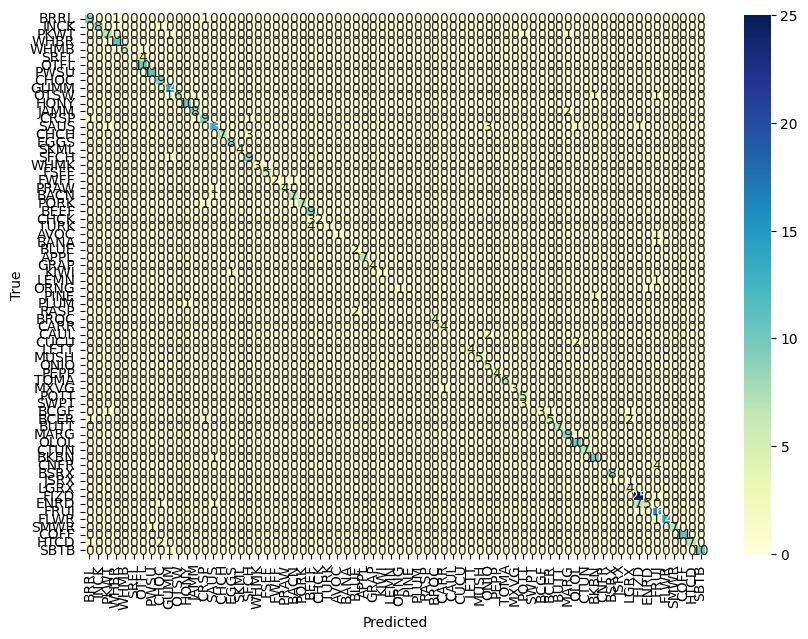

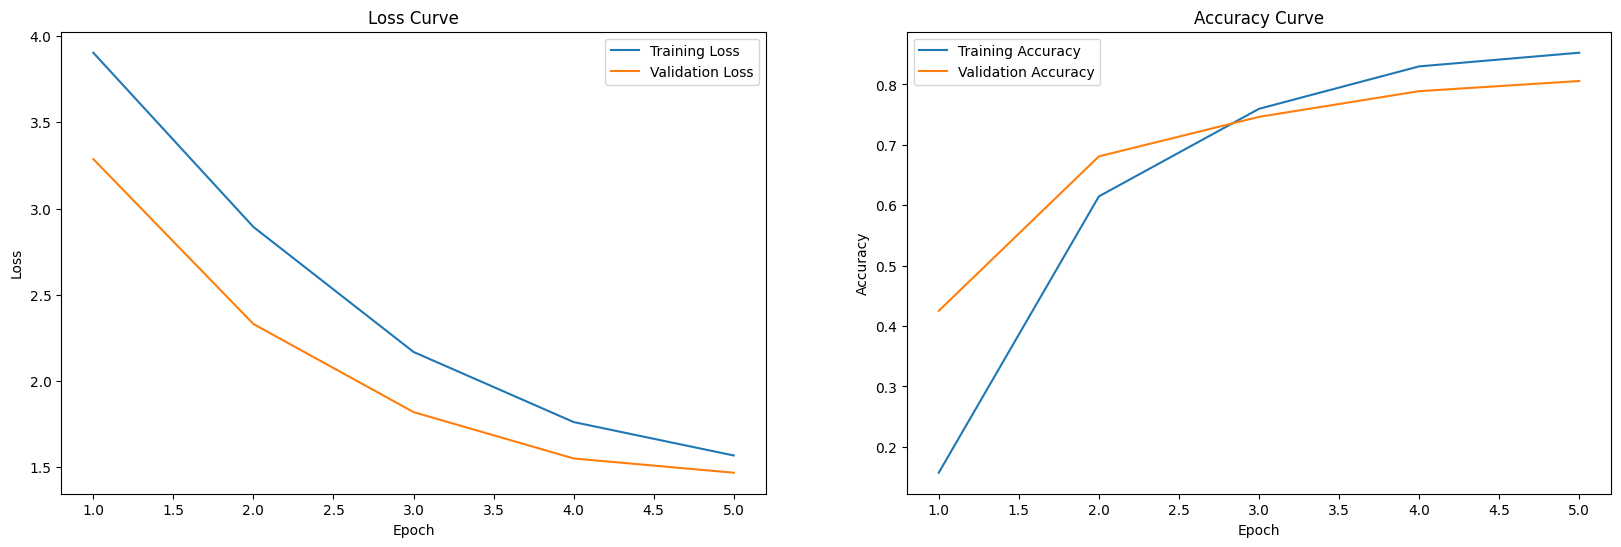

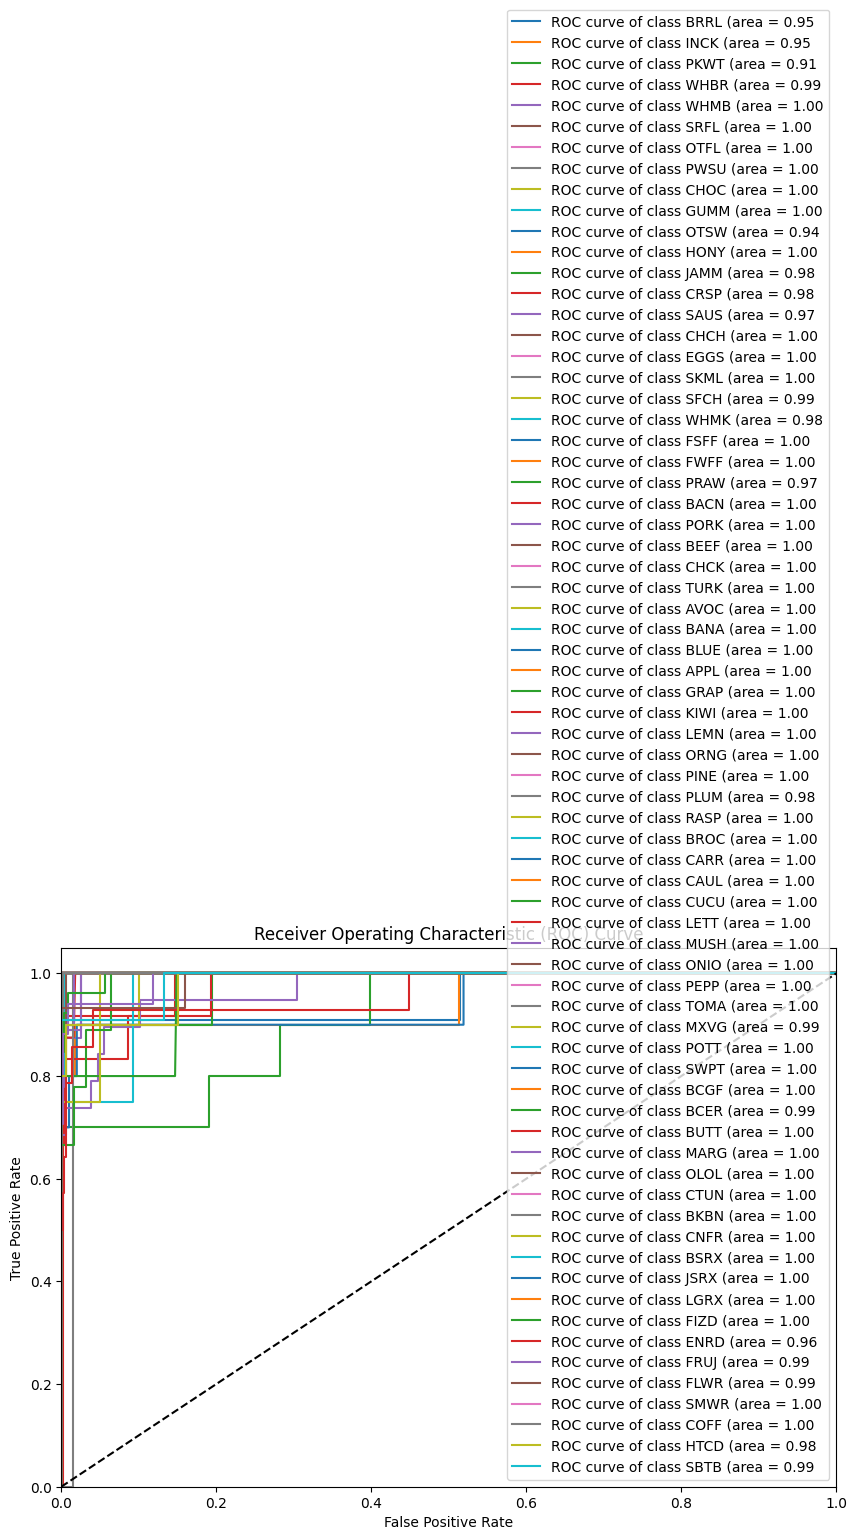

In [32]:
COLS = ["CATEGORY", "NAME"]
# Original LR = 1e-5
EPOCHS = 5
BATCH_SIZE = 3
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 0.001
GRADIENT_CLIPPING = 0.5
DROPOUT_RATE = 0.1
# Model 1: multi-class classification version 
torch.cuda.empty_cache()
model_trainer(
    DATA_SET_PATH='../Data/SingleDataset.csv',
    SAVE_PATH='models/fmcm_model',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="Food And Beverage Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()



